# Recurso energetico disponible

En el presente análisis realizaremos una estimación de la producción de energía eléctrica por metro cuadrado de superficie de paneles solares. Para lograr esto se realizará una estimación de la disponibilidad de recurso energético disponible en el plano generalizado que representará el plano de proyección conformado por los paneles solares y posterior a eso, se realizará una corrección de la energía eléctrica generada a partir de este recurso disponible, la eficiencia de producción de los paneles y la pérdida de eficiencia debida a la temperatura ambiental.



In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Crear dataframe con los sets de datos de NREL
import utils.nrel_system.parse_nrel as parse_nrel

merida = [
    "data/mx-merida/2018.csv",
    "data/mx-merida/2019.csv",
    "data/mx-merida/2020.csv"
]

nrel, L = parse_nrel.main(merida)

In [3]:
# Calcular (e inyectar) variables de temporales, de geometría solar y valores de irradiancia por componentes difusa y directa
import utils.physical_system.setup_variables as setup_variables
nrel = setup_variables.main(nrel,L)

In [4]:
# Realizar cálculo de proyección de irradiancia en plano generalizado utilizando como parámetros de plano 
#     el ángulo acimutal solar y el ángulo de inclinación planar
import utils.projection_system.setup_projection as setup_projection

## Cálculo de recurso energético disponible

Teniendo la posibilidad de calcular la irradiancia proyectada en un plano generalizado parametrizado por los parámetros de orientación acimutal e inclinación con respecto al suelo, es posible simular múltiples configuraciones al varias estos parámetros, calcular la irrandiancia proyectada y con eso, calcular la cantidad de energía total que fluye a través del plano y que es posible almacenar como energía eléctrica.

Para lograr esto, estimaremos el recurso energético disponible para un rango discreto de valores enteros de BETA. A partir de esto generaremos la cantidad total de recurso energético acumulado para diferentes periodos de tiempo, siendo el de mayor interés el recurso energético acumulado a lo largo de un año. 

Con esto lograremos obtener una lista de _irradiaciones_ en los periodos de tiempo de interés para el rango definido de ángulos de inclinación, que una vez graficadas podrán apreciarse como una curva aproximadamente contínua con un valor máximo de _irradiación_ para un ángulo de inclinación específico. 


In [5]:
# Importamos librería de estimación de producción de energía para un plano parametrizado
import utils.forecast_system.setup_production_forecast as setup_production_forecast

def forecast_nrel(nrel,BETA,B=0):
    # Definimos el set de columnas de interés para el presente análisis de recurso energético
    df = setup_projection.main(nrel,B,BETA=BETA)
    df = setup_production_forecast.main(df)
    cols = ['YEAR','MONTH','DAY','HOUR','MINUTE','TEMPERATURE','A','ALPHA','BETA','I_PROJ','WH_SQM']
    return df[cols]

## Irradiación a lo largo de tres años

Irradiación se define como la cantidad de irradiancia proyectada en una superficie a lo largo de un periodo de tiempo específico, en este caso el periodo lo definimos de tres años por ser el periodo especificado para los sets de datos disponibles. Sus unidades son Wh / m^2 y es una medida de energía.

In [6]:
BETA_LIST = np.arange(20,30)
for BETA in BETA_LIST:
    nrel_BETA = forecast_nrel(nrel,BETA)
    nrel['WH_SQM_'+str(BETA)] = nrel_BETA.WH_SQM
    
    
def print_cols(df):
    cols = '|'
    for c in df.columns:
        cols = cols + c + '|'
    print('Columns: ' + cols)
    
print_cols(nrel)

Columns: |YEAR|MONTH|DAY|HOUR|MINUTE|MINS_SINCE_EQUINOX|TEMPERATURE|DNI|DHI|GHI|GI|X_DIF|X_DIR|Z|D|H|A|ALPHA|B|BETA|WH_SQM_20|WH_SQM_21|WH_SQM_22|WH_SQM_23|WH_SQM_24|WH_SQM_25|WH_SQM_26|WH_SQM_27|WH_SQM_28|WH_SQM_29|


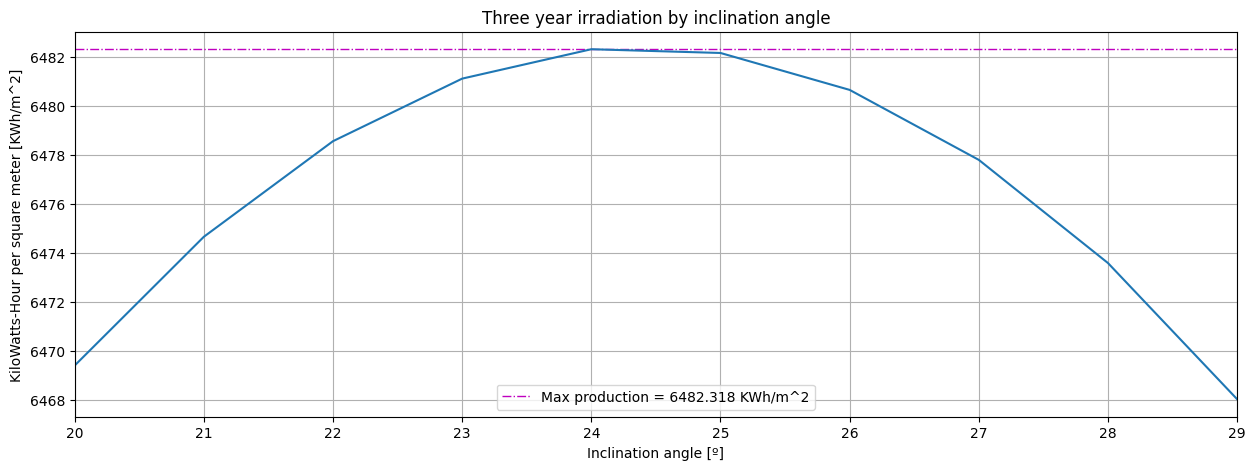

In [7]:
def plot_forecast():
    produced = []
    for BETA in BETA_LIST:
        col = 'WH_SQM_'+str(BETA)
        produced.append(nrel[col].sum()/1000)
    max_prod = np.round(np.max(produced),3)
    fig = plt.gcf()
    fig.set_size_inches(15, 5, forward=True)
    fig.set_dpi(100)
    plt.margins(x=0)
    plt.xticks(BETA_LIST)
    plt.grid(True)
    plt.ylabel('KiloWatts-Hour per square meter [KWh/m^2]')
    plt.xlabel('Inclination angle [º]')
    plt.title('Three year irradiation by inclination angle')
    plt.axhline(y=np.max(max_prod), color='m',linestyle='-.',linewidth=1,label='Max production = ' + str(max_prod) + ' KWh/m^2')
    plt.legend(loc='lower center')
    plt.plot(BETA_LIST,produced)
    plt.show()

plot_forecast()

Gracias a las estimaciones realizadas para múltiples ángulos de inclinación hemos logrado determinar que el ángulo óptimo de irradiación para la irradiancia registrada de los años 2018, 2019 y 2020 es de 24º, con una proyección de energía estimada de 6482.3 KWh por metro cuadrado en el lapso de estos tres años.

## Conclusión

Para los años 2018, 2019 y 2020 el ángulo de irradiación óptima (ángulo en el que existe la proyección de energía máxima) es de 24º. Esto marca una primera aproximación de aceptable fidelidad con respecto al ángulo de inclinación óptimo para la producción de energía con paneles solares. Para poder llegar a este valor de interés, aún hay que realizar un estudio de la eficiencia de conversión de irradiación a energía eléctrica que solo podemos realizarlo con los parámetros de voltaje, potencia y eficiencia de la ficha técnica de un modelo de panel solar específico, ya que la temperatura ambiente juega un rol importante en el aprovechamiento final del recurso energético disponible.